# Data separation
Compressed sensing 

Mohamed BOUSSENA and Ngoc-Tam Le

This project is based on the following articles : 

Data Separation by Sparse Representations
Gitta Kutyniok, 2011
https://arxiv.org/pdf/1102.4527.pdf


Robust PCA? 
Emmanuel J. Candes, Xiaodong Li, Yi Ma, John Wright
https://arxiv.org/pdf/0912.3599.pdf

## Data separation by sparse representations

## Theoretical results
___

The data separation problem is set as follow : Given a vector $x \in \mathcal{H}$ (where $\mathcal{H}$ is assumed to be a Hilbert space) such that $x = x_1 + x_2$, we would like to extract the two components $x_1$ and $x_2$. A general idea underlying data separation is to choose two basis representation $\Phi_1$ and $\Phi_2$ such that $x_1$ and $x_2$ can be represented in a sparse way in one of the two basis basis. Precisely, we would like to choose the basis such that $x_1$ is sparse in $\Phi_1$ and not $\Phi_2$, and vice versa. 

__Definition__ (mutual coherence) : Given a frame $\Phi$ on a Hilbert space $\mathcal{H}$, we define the mutual coherence for $\Phi$ by :

\begin{equation*}
    \mu(\Phi) = \underset{i,j \in I, i \neq j}{max}  \left| \langle \phi_i, \phi_j \rangle \right|
\end{equation*}


The following result gives us the guarantee that solving $l_1$ minimisation is equivalent to the $l_0$ minimisation.

__Theorem 1__: Let $\Phi_1$ and $\Phi_2$ two frames on a Hilbert space $\mathcal{H}$, and $x \in \mathcal{H} \backslash \{0\}$. Then if $x = \left[\Phi_1 \middle| \Phi_2 \right] c$ and 
    
$$\|c \|_0 \leq \frac{1}{2} \left(1 + \frac{1}{\mu\left(\left[\Phi_1 \middle| \Phi_2 \right]\right)} \right)$$

Then the solution of the $l_1$ minimization problem coincide with the solution of the $l_0$ minimization problem.
___

We want to solve the following program :


$$\underset{c_1, c_2}{min}\hspace{0.3cm} \|c_1 \|_1 + \|c_2\|_1$$
$$s.t. x = \left[\Phi_1 \middle|  \Phi_2 \right] \begin{bmatrix}c_1 \\ c_2 \end{bmatrix} $$

The constraint can be rewritten 

We can rewrite it as a linear program

$$min \ \mathbb{1}^T ( c_1^{+} + c_2^{+} + c_1^{-} + c_2^{-}) $$

$$ s.t \hspace{1cm} 
\begin{aligned}
\begin{bmatrix} \Phi_1 & \Phi_2 & -\Phi_1 & -\Phi_2 \end{bmatrix} \begin{bmatrix} c_1\\ c_2 \\ c_1^{-} \\ c_2^{-} \end{bmatrix} = x\\
0 \leq c_i^{+}, 0 \leq c_i^{-}, i=1, 2
\end{aligned}$$

## Application

In [111]:
# required libraries
import cvxpy as cp
import scipy.fftpack as spfft
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

In [34]:
# solve l1 minimization problem and compute mutual coherence
class DataSep():
    
    def __init__(self, basis1, basis2, x):
        self.basis1 = basis1 # ndarray of size n * d1
        self.basis2 = basis2 # ndarray of size n * d2
        self.x = x # 1d array of size n 
    
    def get_sparse_component(self):
        """
        solve the basis pursuit program
        """
        A = np.hstack((self.basis1, self.basis2, -self.basis1, -self.basis2))
        b = self.x
        dim = A.shape[1]
        c = cp.Variable(dim)
        constraints = [A*c==b, 
                      c>=0]
        # define objective function
        obj = cp.Minimize(cp.norm(c, 1))
        prob = cp.Problem(obj, constraints)
        sol = prob.solve(verbose=True)
        
        # separate the two components
        b1_len, b2_len = basis1.shape[1], basis2.shape[1]
        sparse_comp = np.array(c.value)
        sparse_comp1 = sparse_comp[:b1_len] - sparse_comp[b1_len+b2_len: b2_len+2*b1_len]
        sparse_comp2 = sparse_comp[b1_len: b1_len+b2_len] - sparse_comp[b2_len+2*b1_len: ]
        
        return sparse_comp1, sparse_comp2

### Sinus and spike separation

We apply the method to impulse noise removal in 1-dimensional signal. An useful application of this problem is for instance audio declicking.

First, we need to build the frames $\Phi_1$, $\Phi_2$. We will use cosine and dirac basis, with the intuition that the principal source would be sparse in the cosine basis and the impulse noise would be sparse in the dirac basis.

Python package doesn't provide the cosine basis matrix but we can retrieve it from the inverse cosine transform function. To build $\Phi_1$ we use the inverse cosine transform, an apply it to the identity matrix. Let $x \in \mathbb{R}^n$. We have for all $x \in \mathbb{R}^n$, $DCT(x) = D_n x$ where $D_n = DCT(Id_n)$ DCT being computed along the first axis. If $x_1 = \Phi_1 c_1$, then $\Phi_1 = D_n^{-1}= D_n^T$.


$\Phi_2$ is just equal to the identity matrix.

In [167]:
# build phi1 phi2
# number of sample and spikes
n = 400
basis1 = spfft.idct(np.identity(n), norm='ortho', axis=0)
basis2 = np.eye(n)

#### Test on simulated data 

__Allowed sparsity__ 
Allowed sparsity from the condition in theorem 1 give us the value
$$\|c \|_0 \leq \frac{1}{2} \left(1 + \frac{1}{\mu\left(\left[\Phi_1 \middle| \Phi_2 \right]\right)} \right) = 
\frac{1}{2} \left(1 + \sqrt{\frac{n}{2}} \right)$$

In [168]:
print('allowed sparsity') 
print ( (np.sqrt(n/2)+ 1)/2)

allowed sparsity
7.5710678118654755


The criterion is quite constraining. For a signal length of 400, we can't even have a noise rate of 10%. However, we'll see we in practice that the reconstruction can be made.

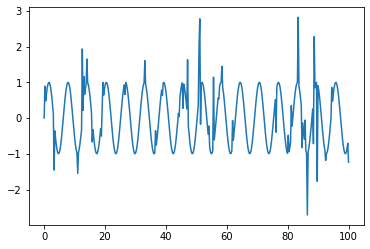

In [169]:
# we test the algorithm on a 10 percent corrupted sinus by a random gaussian noise

# number of spikes
m =n//10

z = np.linspace(0, 100, n)
x = np.sin(z)

# spikes :
amplitude = 1
spike_index = np.random.choice(n, m, replace=False)
spike = np.zeros(n)
spike[spike_index] += amplitude * np.random.randn(m)

x += spike
plt.plot(z, x)

In [170]:
# solve the l1 minimisation problem 
one_dim = DataSep(basis1, basis2, x)
sparse_comp1, sparse_comp2 = one_dim.get_sparse_component()
x1 = np.dot(basis1, sparse_comp1) 
x2 = np.dot(basis2, sparse_comp2)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +2e+04  1e+00  7e-01  1e+00  5e+00    ---    ---    1  1  - |  -  - 
 1  +7.129e+01  +7.302e+01  +2e+04  7e-01  4e-01  2e+00  4e+00  0.3383  5e-01   0  0  0 |  0  0
 2  +6.978e+01  +7.224e+01  +1e+04  3e-01  1e-01  3e+00  2e+00  0.6407  3e-01   0  0  0 |  0  0
 3  +7.600e+01  +7.700e+01  +4e+03  1e-01  4e-02  1e+00  8e-01  0.7287  2e-01   0  0  0 |  0  0
 4  +7.934e+01  +7.966e+01  +2e+03  4e-02  1e-02  3e-01  3e-01  0.6936  1e-01   1  0  0 |  0  0
 5  +8.024e+01  +8.035e+01  +7e+02  2e-02  6e-03  1e-01  1e-01  0.6364  1e-01   1  0  0 |  0  0
 6  +8.062e+01  +8.066e+01  +2e+02  6e-03  2e-03  4e-02  5e-02  0.6773  8e-02   1  0  0 |  0  0
 7  +8.088e+01  +8.090e+01  +1e+02  2e-03  9e-04  2e-02  2e-02  0.6116  6e-02   1  0  0 |  0  0
 8  +8.099e+01  +8.099e+01  +4e+01  1e-03  4e-

length of c:800
number of non nul component:393


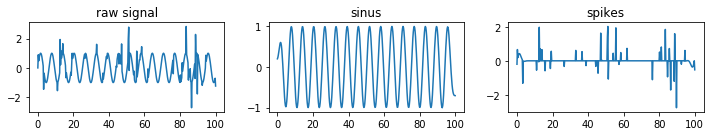

In [172]:
print('length of c:'+ str(2*n))
print('number of non nul component:' +str(np.sum(sparse_comp1 > 0)+ np.sum(sparse_comp2 > 0)))
plt.figure(figsize = (10, 2))
plt.subplot(1,3,1)
plt.plot(z, x)
plt.title('raw signal')
plt.subplot(1,3,2)
plt.plot(z, x1)
plt.title('sinus')
plt.subplot(1,3,3)
plt.plot(z, x2)
plt.title('spikes')

Due to the signal length, we observe some anomaly at the beginning. It's because the signal length doesn't match the period condition of the cosine transform. However, the sinusoid and the spikes seem to be separated properly.

#### Fourier basis

The mutual coherence induced by the cosine basis is a bit larger than that with a Fourier basis. We can make the same simulation and construct the $\Phi_1$ frame the same way than precedently for the Fourier basis.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +2e+04  9e-01  8e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +1.103e+02  +1.113e+02  +2e+04  7e-01  5e-01  2e+00  2e+00  0.2805  4e-01   1  1  1 |  0  0
 2  +2.119e+02  +2.136e+02  +1e+04  4e-01  2e-01  2e+00  2e+00  0.4988  3e-01   1  1  1 |  0  0
 3  +2.923e+02  +2.931e+02  +5e+03  1e-01  6e-02  9e-01  6e-01  0.6915  9e-02   1  1  1 |  0  0
 4  +2.771e+02  +2.773e+02  +1e+03  3e-02  2e-02  3e-01  2e-01  0.7215  5e-02   1  1  1 |  0  0
 5  +2.730e+02  +2.731e+02  +5e+02  1e-02  5e-03  8e-02  6e-02  0.7180  9e-02   1  1  1 |  0  0
 6  +2.718e+02  +2.718e+02  +2e+02  3e-03  2e-03  2e-02  2e-02  0.7481  7e-02   1  1  1 |  0  0
 7  +2.715e+02  +2.715e+02  +5e+01  9e-04  5e-04  5e-03  6e-03  0.7593  9e-02   1  1  1 |  0  0
 8  +2.714e+02  +2.714e+02  +1e+01  3e-04  1e-

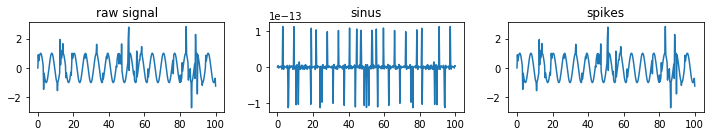

In [174]:
# solve the l1 minimisation problem 
# build phi1 phi2
# number of sample and spikes

basis1 = spfft.ifft(np.identity(n), axis=0)
basis2 = np.eye(n)

one_dim = DataSep(basis1, basis2, x)
x1 = np.dot(basis1, sparse_comp1) 
x2 = np.dot(basis2, sparse_comp2)
sparse_comp1, sparse_comp2 = one_dim.get_sparse_component()
x1 = np.dot(basis1, sparse_comp1) 
x2 = np.dot(basis2, sparse_comp2)

plt.figure(figsize = (10, 2))
plt.subplot(1,3,1)
plt.plot(z, x)
plt.title('raw signal')
plt.subplot(1,3,2)
plt.plot(z, x1)
plt.title('sinus')
plt.subplot(1,3,3)
plt.plot(z, x2)
plt.title('spikes')

The quality of reconstruction is much worse than with the cosine basis. The theorem only give a sufficient condition for solutions from both norm minization to coincide. It doesn't imply that the quality of reconstruction would be greater with a Fourier basis.

### Image reconstruction with Cosine and Dirac basis

We would like to apply the method to reconstruct corrupted image. We make the assumption that given a image vector $x$, $x = x_1 + x_2$ such that $x_1$ represent the entire image, and $x_2$ is a term of noise that is sparse in the Dirac basis. 

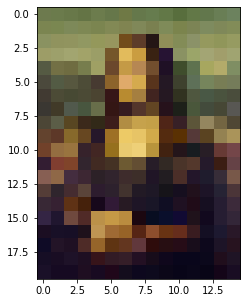

In [99]:
# import image 
img = Image.open('joconde.jpeg').resize((15,20))

plt.figure(figsize = (5,5))
plt.imshow(img, cmap=plt.cm.gray)

In [100]:
# Get gray scale array
img = np.array(img)
gray =  0.2989 * np.array(img)[:, :, 0] + 0.5870 * np.array(img)[:, :, 1] + 0.1140 * np.array(img)[: , :, 2]
print('Image shape:'+ str(gray.shape))

# Erase some samples 
n = gray.shape[0]
m = gray.shape[1]
index = np.arange(n*m)
np.random.shuffle(index)
erase = index[:n*m // 10]
gray = gray.flatten()
gray[erase] = 0
gray = gray.reshape(n, m)

Image shape:(20, 15)


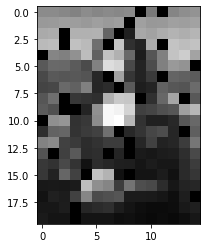

In [101]:
plt.imshow(gray, cmap=plt.cm.gray)

#### Build Cosine and Dirac frames
For the 2-dimensional problem, We build $\Phi_1$ and $\Phi_2$ Parseval frames, here corresponding to cosine and dirac basis.

We define the operator vec such that for $X \in \mathbb{R}^{n \times m}$, $vec(X)$ is the vector obtained by stacking the columns of $x$. 

Let $X \in \mathbb{R^{n \times m}}$. The 2-dimensional cosine transform is computed  from the 1-dimensional cosine transform applied to the row and then, to the columns. We denote $DCT_d$ the d-dimensional discrete transform :

\begin{align*}
DCT_2(X) &= DCT_1(DCT_1(X)^T))^T \\
         &= (D_n(D_m X)^T)^T \\
         &= D_mXD_n^T
\end{align*}
Where $DCT_1$ is computed along the first axis and $D_n = DCT_1(Id_n), D_m = DCT_1(Id_m)$.


If $X$ is decomposed as $X = X_1 + X_2$, the first component is written $x_1 = vec(X_1) = \Phi_1 c_1$. We use a basic property of the operator $vec$ linked to the Kronecker product, that is : $vec(AXB) = (B^T \otimes A) vec(X) $ to get :

$$x_1 = vect(D_m^{-1}C_1(D_n^{-1})^T) = (D_n^{-1} \otimes D_m^{-1}) c_1$$

We take $\Phi_1 = (D_n^{-1} \otimes D_m^{-1}) = (D_n^{T} \otimes D_m^{T}) $.


To get $\Phi_2$, we just stack the flattened matrices of canonical base in $\mathbb{R}^{n \times m}$, so that $\Phi_2 = Id_{nm}$. 

In [102]:
# image dimensions
n, m = gray.shape
# vec operation
x = (gray.T).flatten()

# define the two frames
basis1 = np.kron(
    spfft.idct(np.identity(n), norm='ortho', axis=0),
    spfft.idct(np.identity(m), norm='ortho', axis=0)
    )
basis2 = np.eye(n*m)

two_dim = DataSep(basis1, basis2, x)

In [103]:
sparse_comp1, sparse_comp2 = two_dim.get_sparse_component()


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+06  1e+00  7e-01  1e+00  4e+02    ---    ---    1  1  - |  -  - 
 1  +1.901e+03  +1.982e+03  +1e+06  8e-01  6e-01  8e+01  4e+02  0.2801  8e-01   0  0  0 |  0  0
 2  +7.951e+03  +8.208e+03  +9e+05  4e-01  2e-01  3e+02  2e+02  0.7622  6e-01   0  0  0 |  0  0
 3  +8.382e+03  +8.511e+03  +3e+05  1e-01  5e-02  1e+02  8e+01  0.7448  1e-01   1  0  0 |  0  0
 4  +9.732e+03  +9.776e+03  +1e+05  4e-02  2e-02  4e+01  3e+01  0.6644  7e-02   1  0  0 |  0  0
 5  +1.021e+04  +1.022e+04  +5e+04  2e-02  6e-03  2e+01  1e+01  0.6304  8e-02   1  0  0 |  0  0
 6  +1.043e+04  +1.043e+04  +2e+04  7e-03  3e-03  6e+00  6e+00  0.6531  1e-01   1  0  0 |  0  0
 7  +1.053e+04  +1.053e+04  +7e+03  2e-03  9e-04  2e+00  2e+00  0.7210  1e-01   1  0  0 |  0  0
 8  +1.057e+04  +1.057e+04  +3e+03  1e-03  4e-

In [104]:
x1 = np.dot(basis1, sparse_comp1) 
x2 = np.dot(basis2, sparse_comp2)

x1 = x1.reshape(m, n).T
x2 = x2.reshape(m, n).T

Text(0.5, 1.0, 'Reconstructed image')

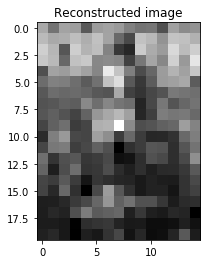

In [105]:
plt.imshow(x1, cmap=plt.cm.gray)
plt.title('Reconstructed image')

We can't really discuss about the quality of the reconstruction since the image resolution is low. It appears that this method is not really scalable due to the kronecker product complexity (it generates a $n m$-matrix in the constraint), so we can't simply use cvxpy solvers on this form of the problem.

## Robust PCA

## Theoretical results

We set the separation problem as follow. Let $M \in \mathbb{R}^{n_1 \times n_2}$ and we make the assumption M is the sum of low rank matrix $L$ and a sparse component $S$.

The following theorem give a sufficient condition to retrieve the two component from an optimisation procedure called **Principal Component Pursuit** (PCP) : 

The PCP program is the following : 

$$ \underset{L,\: S}{min} \hspace{0.3cm} \| L \|_* + \lambda \| S \|_1, \hspace{0.3cm} M = L + S $$
___
First we make the two following assumptions on the low rank component $L$, called the __incoherence condition__ :

Let $L = U\Sigma V^* = \sum_{i=1}^n \sigma u_i v_i^*$ be the SVD expression of $L$. The two conditions are :
\begin{equation}
\underset{i}{max} \|U^* e_i \|^2 \leq \sqrt{\frac{\mu r}{n_1}}, \hspace{0.3cm}  \underset{i}{max} \|V^* e_i \|^2 \leq \sqrt{\frac{\mu r}{n_2}} 
\end{equation}
and 
\begin{equation}
\|UV^* \| \leq \sqrt{  \frac{\mu r}{n_1 n_2} }
\end{equation}


Then we have the following theorem (with $n_{(1)} = max(n_1, n_2)$ and $n_{(2)} = min(n_1, n_2)$):

__Theorem 2__: Suppose $L_0$ is $n \times n$, obeys the incoherence condition, and that the support set of $S_0$ is uniformly
distributed among all sets of cardinality m. Then there is a numerical constant $c$ such that with probability at least $1-cn^{-10}$ (over the choice of support of $S_0$), Principal Component Pursuit with $\lambda = 1/\sqrt{n}$ is exact, i.e. $\hat{L} = L_0$ and $\hat{S} = S_0$, provided that :

\begin{equation}
rank(L_0) \leq \rho rn \mu^{-1}(log n)^{-2}
\ \text{and}\ m \leq \rho_s n^2
\end{equation}

Above, $\rho_r$ and $\rho_s$ are positive numerical constants. In the general rectangular case where $L_0$ is
$n_1 \times n_2$, PCP with $\lambda = 1/\sqrt{n_{max}}$ succeeds with probability at least $1-cn_{(1)}^{-10}$, provided that $rank(L_0) \leq \rho_r n_{(2)} \mu_{-1}(log n_{(1)} )^{-2}$ and $m \leq \rho_s n_1 n_2$



The value $\lambda = \frac{1}{\sqrt{max(n, m})}$ always verify the condition but in practical case we will adjust it for better performances.

In [175]:
# We implement the Augmented Lagrangian Method with alternated directions
# given in the article

class RobustPCA:

    def __init__(self, M, mu=None, lmbda=None):
        
        """
        M: matrix to separate
        """
        self.M = M
        self.S = np.zeros(self.M.shape)
        self.Y = np.zeros(self.M.shape)

        if mu:
            self.mu = mu
        else:
            # default value given in the article
            self.mu = np.prod(self.M.shape) / (4 * np.linalg.norm(self.M, ord='fro'))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            # default lambda value given in the article
            self.lmbda = 1 / np.sqrt(np.max(self.M.shape))
    
    # shinkrage operator with treshold tau
    def shrink(self, A, tau):
        return np.sign(A) * np.maximum((np.abs(A) - tau), np.zeros(A.shape))
    
    # svd tresholding
    def svd_treshold(self, A, tau):
        U, s, V = np.linalg.svd(A, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(s, tau)), V))
    
    # perform algorithm iterations
    def alm_ad(self, tol=None, max_iter=2000, iter_print=200, iter_show=500):
        """
        tol: tolerance value for error
        max_iter: max iterations to perform
        iter_print: nb of iterations between printing error
        iter_show: nb of iterations betweenshowing images
        """
        i = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.M.shape)

        if tol:
            tol_ = tol
        else:
            # we'd like an error quite small relatively to the norm of M
            tol_ = 1e-7 * np.linalg.norm(self.M, ord='fro')

        while (err > tol_) and i < max_iter:
            Lk = self.svd_treshold(self.M - Sk + 
                                   self.mu_inv * 
                                   Yk, self.mu_inv)
            Sk = self.shrink(self.M - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.M - Lk - Sk)
            err = np.linalg.norm(self.M - Lk - Sk, ord='fro')
            i += 1
            if (i % iter_print) == 0 or i == 1 or i > max_iter or err <= tol_:
                print('iteration: {0}, error: {1}'.format(i, err))
            if i % iter_show == 0:
                plt.figure(figsize=(10,5))
                plt.subplot(1,2,1)
                plt.imshow(Lk, cmap=plt.cm.gray)
                plt.title("LOW RANKING IMAGE (proportion = {} per cent)".format(proportion) + '; iteration' + str(i))
                plt.subplot(1,2,2)
                plt.imshow(Sk, cmap=plt.cm.gray)
                plt.title("SPARSE IMAGE"+'; iteration' + str(i))
                

        self.L = Lk
        self.S = Sk
        return Lk, Sk

In [112]:
# Truncated SVD and noise adding (testing purpose)
def truncated_svd(image, rank = 50):
    U, s, V = np.linalg.svd(image)
    n = s.size
    s[rank-n:-1] = 0
    return U, s, V  

def mask(u, v, proportion = 0.2):
    mat_mask = np.random.binomial(1, proportion, size =  (u, v))
    print("We observe {} per cent of the entries of a {}*{} matrix".format(100 * mat_mask.mean(),u, v))
    return mat_mask

We observe 80.171904536862 per cent of the entries of a 184*184 matrix


Text(0.5, 1.0, 'Corrupted image')

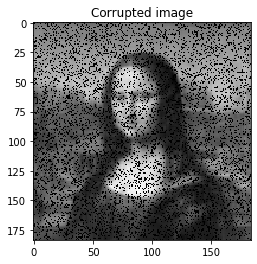

In [163]:
size = 184
img = Image.open("joconde.jpeg")
img = np.array(img)

gray = gray =  0.2989 * np.array(img)[:, :, 0] + 0.5870 * np.array(img)[:, :, 1] + 0.1140 * np.array(img)[: , :, 2]
gray = gray[:size, :size]
rank = 20

# We reduce the rank of the original image
U, sr, V = truncated_svd(gray, rank)
S_r = np.diag(sr)
image_r = np.dot(U, np.dot(S_r, V))


# We destroy some pixels
proportion = 0.8
u, v = image_r.shape
mat_mask = mask(u, v, proportion)

image_raw = mat_mask * image_r
plt.imshow(image_raw, cmap=plt.cm.gray)
plt.title('Corrupted image')

iteration: 1, error: 19.423883820568356
iteration: 200, error: 0.06784243851971317
iteration: 400, error: 0.1853197597448841
iteration: 600, error: 0.035337330019560534
iteration: 800, error: 0.033643466535052464
iteration: 1000, error: 0.02277743406490623
iteration: 1200, error: 0.02734908947429825
iteration: 1400, error: 0.029407552553966324
iteration: 1600, error: 0.02693906922556026
iteration: 1800, error: 0.02182562640196984
iteration: 2000, error: 0.020861991738995795
iteration: 2200, error: 0.015543563702399942
iteration: 2400, error: 0.010902501710446927
iteration: 2600, error: 0.0072344996732862646
iteration: 2800, error: 0.004806271884386969
iteration: 3000, error: 0.0033989421472112036


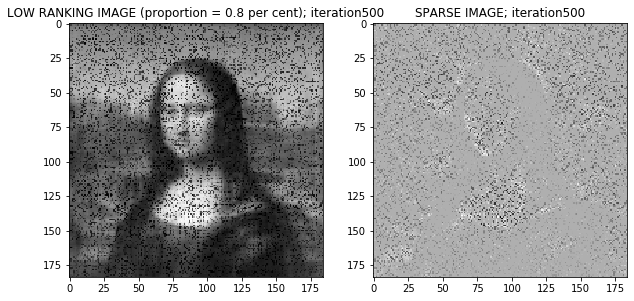

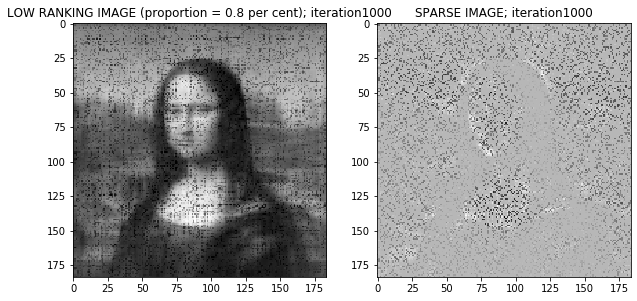

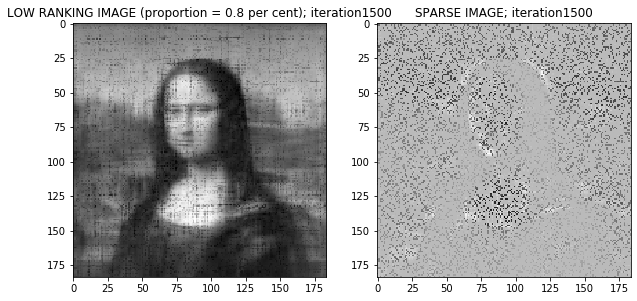

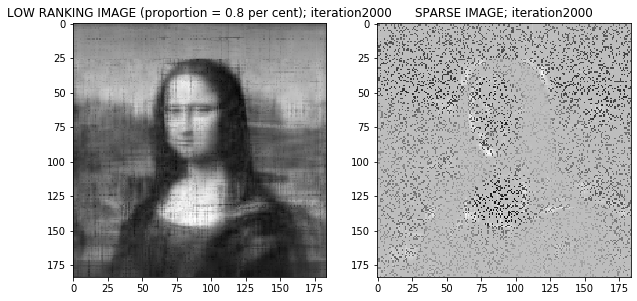

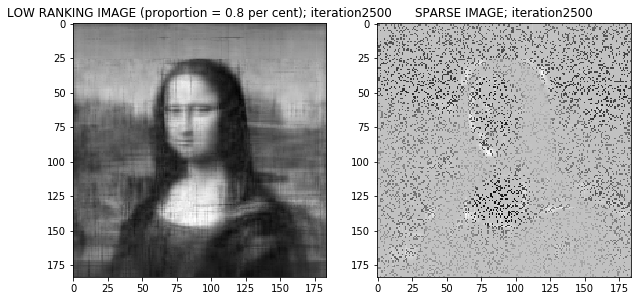

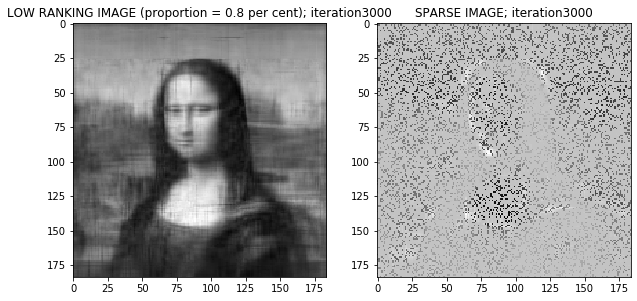

In [164]:
R = RobustPCA(image_raw)
L, S = R.alm_ad(tol=None, max_iter=3000, iter_print=200, iter_show=500)

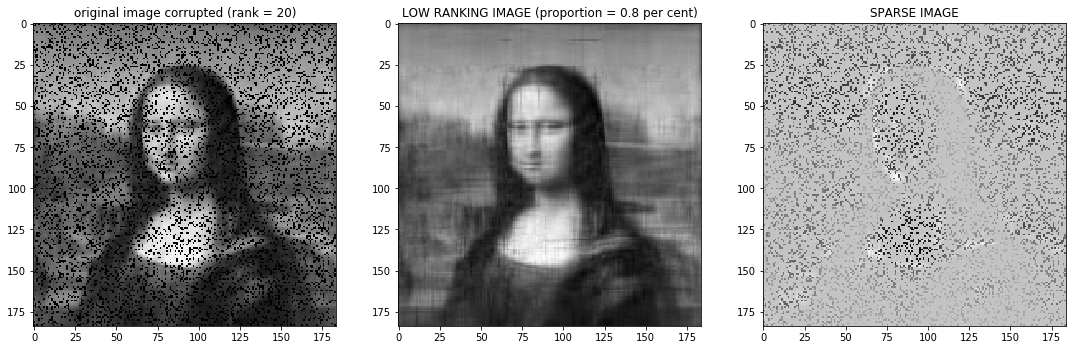

In [165]:
plt.figure(figsize = (15, 10))
plt.subplot(1,3,1)
plt.imshow(image_raw, cmap=plt.cm.gray)
plt.title("original image corrupted (rank = {})".format(rank))
plt.subplot(1,3,2)
plt.imshow(L, cmap=plt.cm.gray)
plt.title("LOW RANKING IMAGE (proportion = {} per cent)".format(proportion))
plt.subplot(1,3,3)
plt.imshow(S, cmap=plt.cm.gray)
plt.title("SPARSE IMAGE")
plt.tight_layout()


We retrieve quite well the original image for 20% corruption noise.